## Bayesian Network Modeling

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pandas as pd
import itertools
from math import log2

In [2]:
data = pd.read_csv("filtered_sequences-v1.csv")

In [4]:
data.head()

,Sequence ID,Failure Mode,Q1,Q2,Q3,Q4,Q5,Q6,Total Duration,Sequence
0,1,LH need to be step initialized,No,Yes,-,-,-,-,25,Q1 > Q2
1,2,System hickup,No,No,No,Yes,-,-,60,Q1 > Q2 > Q3 > Q4
2,3,LH board problem,Yes,-,-,-,-,-,15,Q1
3,4,2DIB connection or IMCR communication NOK,No,No,Yes,-,-,-,40,Q1 > Q2 > Q3
4,5,Broken PSU,No,No,No,No,Yes,-,90,Q1 > Q2 > Q3 > Q4 > Q5


In [5]:
# Count occurrences of each failure mode
failure_mode_counts = data["Failure Mode"].value_counts().reset_index()
failure_mode_counts.columns = ["Failure Mode", "Occurrences"]

In [6]:
failure_mode_counts

,Failure Mode,Occurrences
0,LH board problem,12
1,LH need to be step initialized,9
2,2DIB connection or IMCR communication NOK,9
3,System hickup,6
4,Broken PSU,1


In [7]:
# Count occurrences of each question with "Yes" answers only
question_yes_counts = {}
for q in ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6"]:
    yes_count = data[q].value_counts().get("Yes", 0)
    question_yes_counts[q] = yes_count

question_yes_counts_df = pd.DataFrame(list(question_yes_counts.items()), columns=["Question", "Yes"])
print(question_yes_counts_df)


  Question  Yes
0       Q1   12
1       Q2    8
2       Q3    9
3       Q4    6
4       Q5    1
5       Q6    0


In [8]:
# Define the Bayesian Network
bn = gum.BayesNet('DiagnosticNetwork')

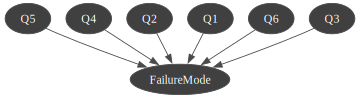

In [9]:
# Define questions
questions = {
    "Q1": "Does LH driver initialize after a reboot of the LH board?",
    "Q2": "Do step initialize LH solve the issue?",
    "Q3": "Did reconnect 2DIB power cable or rebooting the IMCR solve the problem?",
    "Q4": "Did restart solve the problem?",
    "Q5": "Are there any LED's on the PSUs in the IMCR rack red or not burning at all?",
    "Q6": "Are there any red and/or blinking LEDs on the 2DIB?"
}

# Add question nodes to the network
for q_id, q_name in questions.items():
    bn.add(gum.LabelizedVariable(q_id, q_name, 2))  # 2 states: Yes/No

# Define failure modes
failure_modes = [
    "LHBoardProblem",
    "LHNeedToBeStepInitialized",
    "2DIBConnectionOrIMCRCommNOK",
    "SystemHickup",
    "BrokenPSU",
    "Broken2DIBBox",
    "PossibleDamagedCablesIMCRandFlexwave"
]

# Add the FailureMode node
bn.add(gum.LabelizedVariable("FailureMode", "Failure Mode", failure_modes))

# Add arcs from questions to FailureMode
for q_id in questions.keys():
    bn.addArc(q_id, "FailureMode")
    
# Assign Prior Probabilities for Questions
question_priors = {
    "Q1": [0.4, 0.6],
    "Q2": [0.6, 0.4],
    "Q3": [0.5, 0.5],
    "Q4": [0.7, 0.3],
    "Q5": [0.9, 0.1],
    "Q6": [1.0, 0.0]
}

# # Define prior probabilities for each question 
# # (50/50 as default)
# for q_id in questions.keys(): 
#     bn.cpt(q_id).fillWith([0.5, 0.5])

for q_id, prior in question_priors.items():
    bn.cpt(q_id).fillWith(prior)

# Define CPT for FailureMode using historical data
historical_data = {
    "LHBoardProblem": 0.32432432432432434,
    "LHNeedToBeStepInitialized": 0.24324324324324326,
    "2DIBConnectionOrIMCRCommNOK": 0.24324324324324326,
    "SystemHickup": 0.16216216216216217,
    "BrokenPSU": 0.02702702702702703,
    "Broken2DIBBox": 0.0,
    "PossibleDamagedCablesIMCRandFlexwave": 0.0
}

failure_mode_cpt = bn.cpt("FailureMode")
for evidence_dict in itertools.product([0, 1], repeat=len(questions)):
    evidence_dict = dict(zip(questions.keys(), evidence_dict))
    yes_count = sum(evidence_dict.values())
    if yes_count == 1:  # Only one "Yes" allowed
        yes_question = [q for q, v in evidence_dict.items() if v == 1][0]
        probabilities = [historical_data.get(fm, 0) if fm == failure_modes[list(questions.keys()).index(yes_question)] else 0
                         for fm in failure_modes]
    else:  # No "Yes" or multiple "Yes" are invalid
        probabilities = [0] * len(failure_modes)
    failure_mode_cpt[evidence_dict] = probabilities

# Visualize Bayesian Network
gnb.showBN(bn)

In [10]:
# Define entropy function
def entropy(prob):
    """Calculate entropy reduction of a probability distribution."""
    if not prob or sum(prob) == 0:
        return 0
    return -sum(p * log2(p) for p in prob if p > 0)

# Define function to calculate information gain
def calculate_information_gain(bn, ie, question, target="FailureMode"):
    try:
        prior_entropy = entropy(ie.posterior(target).tolist())
        # Posterior Entropy for Yes
        ie.setEvidence({question: 1})
        posterior_yes = entropy(ie.posterior(target).tolist())
        ie.eraseEvidence(question)
        # Posterior Entropy for No
        ie.setEvidence({question: 0})
        posterior_no = entropy(ie.posterior(target).tolist())
        ie.eraseEvidence(question)
        # Weighted Posterior Entropy
        p_yes = bn.cpt(question)[1]  # P(Yes)
        p_no = 1 - p_yes  # P(No)
        posterior_entropy = p_yes * posterior_yes + p_no * posterior_no
        # Information Gain results
        return prior_entropy - posterior_entropy
    except Exception as e:
        print(f"Error with {question}: {e}")
        return 0

# Initialize the inference engine
ie = gum.LazyPropagation(bn)

# Define question costs
question_costs = {"Q1": 15, 
                  "Q2": 10, 
                  "Q3": 15, 
                  "Q4": 20, 
                  "Q5": 30, 
                  "Q6": 45
                }

# Count "Yes" answers from historical data
question_yes_counts = {"Q1": 12, 
                       "Q2": 8, 
                       "Q3": 9, 
                       "Q4": 6, 
                       "Q5": 1, 
                       "Q6": 0
                    }

total_resolutions = sum(question_yes_counts.values())

# Normalize to calculate weights
# question_weights = {q: count / total_resolutions for q, count in question_yes_counts.items()}
smoothing_factor = 0.01

question_weights = {q: (count + smoothing_factor) / (total_resolutions + len(question_yes_counts) * smoothing_factor)
                    for q, count in question_yes_counts.items()}


# Simulate the process
simulated_answers = {"Q1": 0, "Q2": 0, "Q3": 0, "Q4": 1, "Q5": 0, "Q6": 0}
# Simulate the process
current_evidence = {}
asked_questions = []

while True:
    remaining_questions = [q for q in question_costs if q not in asked_questions]
    if not remaining_questions:
        break

    utilities = {}
    for q in remaining_questions:
        ig = calculate_information_gain(bn, ie, q, "FailureMode")
        if ig is not None:  # Skip questions causing errors
            utility = (ig / question_costs[q]) * question_weights[q]
            utilities[q] = utility
            print(f"Utility for {q}: {utility:.4f} (IG: {ig:.4f}, Cost: {question_costs[q]}, Weight: {question_weights[q]:.4f})")

    if not utilities or max(utilities.values()) == 0:
        print("No valid utilities, falling back to weight-to-cost ratio.")
        fallback_question = max(remaining_questions, key=lambda q: question_weights[q] / question_costs[q])
        asked_questions.append(fallback_question)
        current_evidence[fallback_question] = simulated_answers[fallback_question]
        ie.setEvidence(current_evidence)
        print(f"Selected Fallback Question: {fallback_question}")
        continue

    best_question = max(utilities, key=utilities.get)
    asked_questions.append(best_question)
    current_evidence[best_question] = simulated_answers[best_question]
    ie.setEvidence(current_evidence)

    current_entropy = entropy(ie.posterior("FailureMode").tolist())
    print(f"Selected Question: {best_question}, Current Entropy: {current_entropy:.4f}")
    if current_entropy < 0.05:
        break

print("Optimized Sequence:", asked_questions)

Utility for Q1: 0.0253 (IG: 1.1409, Cost: 15, Weight: 0.3331)
Utility for Q2: 0.0212 (IG: 0.9538, Cost: 10, Weight: 0.2221)
Utility for Q3: 0.0186 (IG: 1.1184, Cost: 15, Weight: 0.2499)
Utility for Q4: 0.0059 (IG: 0.7070, Cost: 20, Weight: 0.1667)
Utility for Q5: 0.0002 (IG: 0.1957, Cost: 30, Weight: 0.0280)
Error with Q6: [pyAgrum] Several evidence/CPT are incompatible together (proba=0): some evidence entered into the Bayes net are incompatible (their joint proba = 0)
Utility for Q6: 0.0000 (IG: 0.0000, Cost: 45, Weight: 0.0003)
Selected Question: Q1, Current Entropy: 1.4755
Utility for Q2: 0.0155 (IG: 0.6982, Cost: 10, Weight: 0.2221)
Utility for Q3: 0.0186 (IG: 1.1184, Cost: 15, Weight: 0.2499)
Utility for Q4: 0.0059 (IG: 0.7070, Cost: 20, Weight: 0.1667)
Utility for Q5: 0.0002 (IG: 0.1957, Cost: 30, Weight: 0.0280)
Error with Q6: [pyAgrum] Several evidence/CPT are incompatible together (proba=0): some evidence entered into the Bayes net are incompatible (their joint proba = 0)
Uti

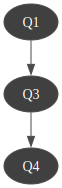

In [11]:
# Visualize question sequence
sequence_bn = gum.BayesNet('QuestionSequence')
for q in asked_questions:
    sequence_bn.add(gum.LabelizedVariable(q, questions[q], 2))
for i in range(len(asked_questions) - 1):
    sequence_bn.addArc(asked_questions[i], asked_questions[i + 1])

gnb.showBN(sequence_bn)

In [12]:
# Calculate the probabilities for each question based on its previous occurrence in the data dataframe
question_probs = {}
for q in ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6"]:
    total_responses = data[q].notna().sum()  # Total valid responses for the question
    yes_responses = (data[q] == 1).sum()  # Count of "Yes" responses
    question_probs[q] = yes_responses / total_responses if total_responses > 0 else 0

print("Question Probabilities:", question_probs)

Question Probabilities: {'Q1': 0.0, 'Q2': 0.0, 'Q3': 0.0, 'Q4': 0.0, 'Q5': 0.0, 'Q6': 0.0}


In [13]:
# bn.cpt("Q1")
bn.cpt("Q2")
# bn.cpt("Q3")
# bn.cpt("Q4")
# bn.cpt("Q5")
# bn.cpt("Q6")
# bn.cpt("FailureMode")

(pyAgrum.Potential@0000026B45405500) 
  Q2               |
0        |1        |
---------|---------|
 0.6000  | 0.4000  |

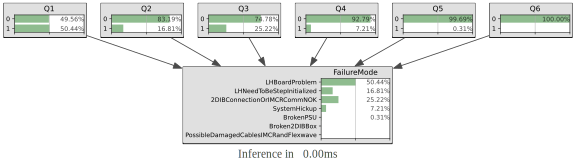

In [ ]:
gnb.showInference(bn)

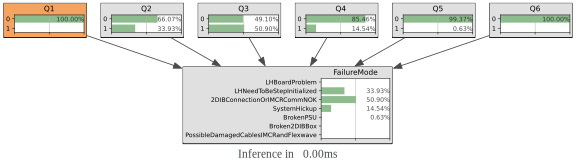

In [ ]:
gnb.showInference(bn, evs={"Q1": 0})

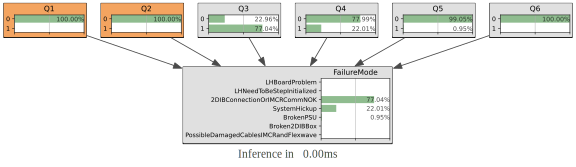

In [ ]:
gnb.showInference(bn, evs={"Q1": 0, "Q2": 0})

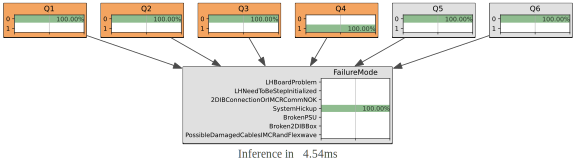

In [ ]:
gnb.showInference(bn, evs={"Q1": 0, "Q2": 0, "Q3": 0, "Q4": 1})

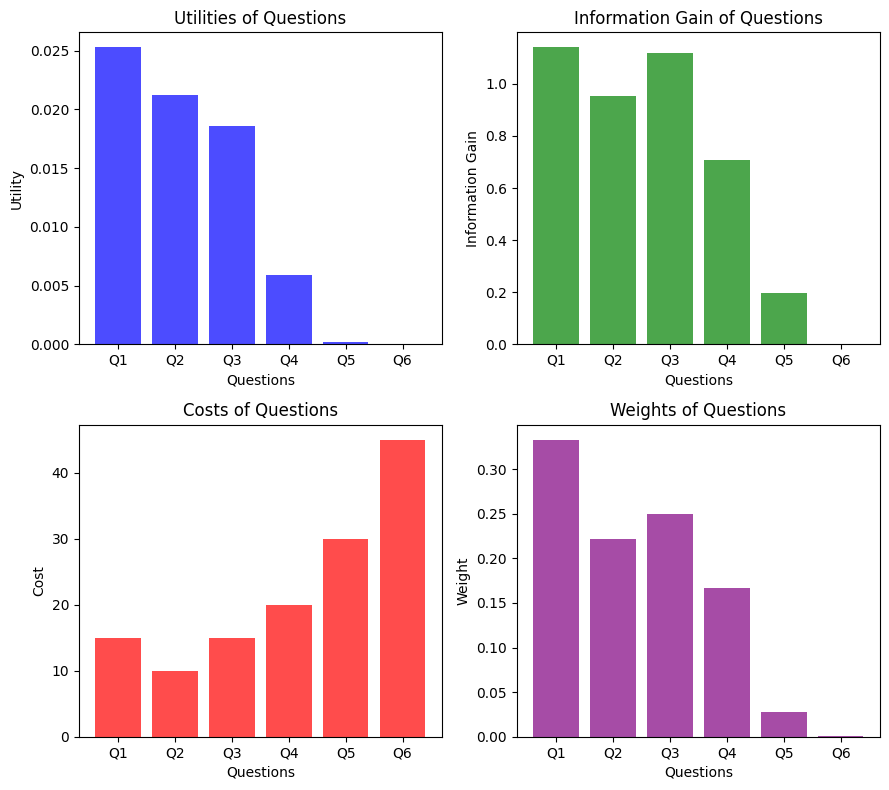

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the metrics
questions = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']
utilities = [0.0253, 0.0212, 0.0186, 0.0059, 0.0002, 0.0]
information_gain = [1.1409, 0.9538, 1.1184, 0.7070, 0.1957, 0.0]
costs = [15, 10, 15, 20, 30, 45]
weights = [0.3331, 0.2221, 0.2499, 0.1667, 0.0280, 0.0003]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(9, 8))

# Utility
axs[0, 0].bar(questions, utilities, color='blue', alpha=0.7)
axs[0, 0].set_title('Utilities of Questions')
axs[0, 0].set_ylabel('Utility')
axs[0, 0].set_xlabel('Questions')

# Information Gain
axs[0, 1].bar(questions, information_gain, color='green', alpha=0.7)
axs[0, 1].set_title('Information Gain of Questions')
axs[0, 1].set_ylabel('Information Gain')
axs[0, 1].set_xlabel('Questions')

# Costs
axs[1, 0].bar(questions, costs, color='red', alpha=0.7)
axs[1, 0].set_title('Costs of Questions')
axs[1, 0].set_ylabel('Cost')
axs[1, 0].set_xlabel('Questions')

# Weights
axs[1, 1].bar(questions, weights, color='purple', alpha=0.7)
axs[1, 1].set_title('Weights of Questions')
axs[1, 1].set_ylabel('Weight')
axs[1, 1].set_xlabel('Questions')

# Adjust layout
plt.tight_layout()
plt.show()